<a href="https://colab.research.google.com/github/laaksonenl/machine-learning/blob/master/bank_marketing_decision_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bank markerting classification with decision trees

**Goal:**

The main goal is to develop a predictive model which will tell if a client is open to create a term deposit based on the client's characteristics

**Hypothesis:**

The base hypothesis is that the wealthier, middle-aged people are the most potential customers in regards of the deposit.

**Data Set Information:**

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

There are four datasets:
1) bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]
2) bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
3) bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs).
4) bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs).
The smallest datasets are provided to test more computationally demanding machine learning algorithms (e.g., SVM).

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

In [1]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip 
! unzip /content/bank.zip

--2020-10-03 11:18:25--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 579043 (565K) [application/x-httpd-php]
Saving to: ‘bank.zip’

bank.zip            100%[===================>] 565.47K   616KB/s    in 0.9s    

2020-10-03 11:18:26 (616 KB/s) - ‘bank.zip’ saved [579043/579043]

Archive:  /content/bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


In [2]:
import pandas as pd

df = pd.read_csv('/content/bank-full.csv', sep=';')

In [3]:
print(df.shape)

(45211, 17)


## Exploratory analysis

In [4]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


### Numerical features

In [6]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


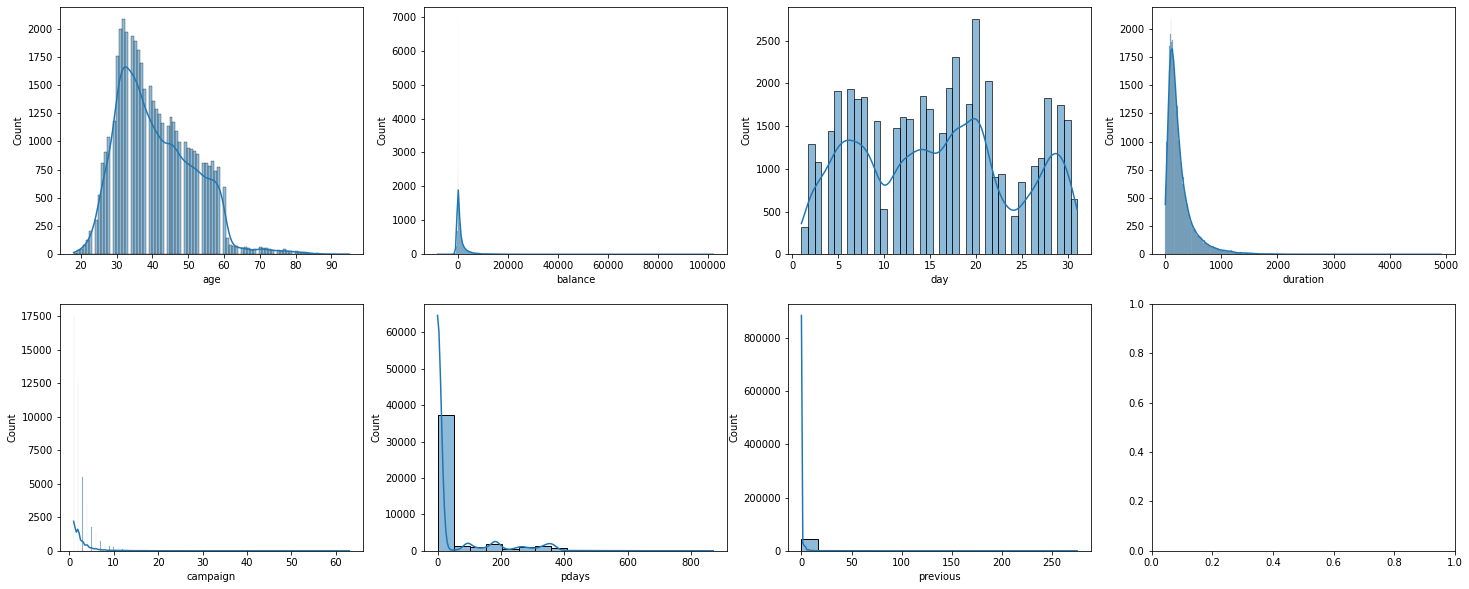

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_numericals(data, features):
  fig, axes = plt.subplots(2,4, figsize=(25,10))
  for ax, f in zip(axes.ravel(), features):
    sns.histplot(data[f], ax=ax, kde=True)

numericals = df.select_dtypes([np.number]).columns
plot_numericals(df, numericals)

#### Age
Main focus has been on people with age between 30 and 40. Young people might not have that much extra cash and old people might not want to take term deposit, at least not for years forward.

#### Account balance (eur)
Most of the people have balance between 0 and 10 000 euros

#### Last contact day of the month
Does not tell much, this is column should be analyzed with month feature which at this point is in categorical format (string values).
Days with less contacts might fall in weekends.

#### Phone call duration
On average calls took 4-5 minutes. There's much longer calls though. The longest reported call has taken 3000 seconds ( = 50 minutes).
Maybe there's correlation with phone duration and term deposits since bank needs to ask all kind of information for term deposit. Of course this depends on the bank's own practices.

#### Contacts during the campaign
Mostly only a few contacts per customer, the data does not tell us if all the contacts are about term deposit. It's hard to imagine situation where bank contacts over 10 times the same client about the same term deposit unless there's lots of confusion between these parties.

#### Number of days passed after the last contact of the previous campaign
Most of the clients were not part of the last campaign thus the peak at the start.

#### Number of contacts before this campaign
No previous or only a few were conducted for the most of the clients.

In [8]:
original_df = df.copy()

def label_to_numerical(df):
  return df['y'].map({ 'yes': 1, 'no': 0}).astype('uint8')

# Convert to numeric so that target will be shown in correlation matrix
df['y'] = label_to_numerical(df)

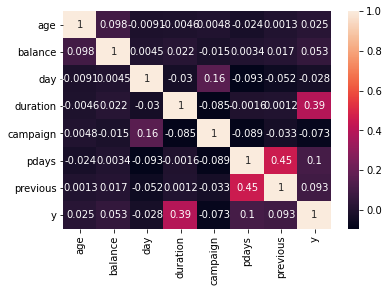

In [9]:
corr = df.corr()
sns.heatmap(corr, annot=True)

Only call duration seems to have decent correlation with target label.
Notice that Pearson's correlation captures only linear correlations.

### Categorical features

In [10]:
categoricals = df.select_dtypes(['object'])
categoricals.head()

,job,marital,education,default,housing,loan,contact,month,poutcome
0,management,married,tertiary,no,yes,no,unknown,may,unknown
1,technician,single,secondary,no,yes,no,unknown,may,unknown
2,entrepreneur,married,secondary,no,yes,yes,unknown,may,unknown
3,blue-collar,married,unknown,no,yes,no,unknown,may,unknown
4,unknown,single,unknown,no,no,no,unknown,may,unknown


In [11]:
def plot_categorical_count(ax, data, feature):
  value_counts = data[feature].value_counts()
  plot = sns.countplot(data=data, x=feature, ax=ax, order = value_counts.index)

  plot.set_xticklabels(
    plot.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'
  )

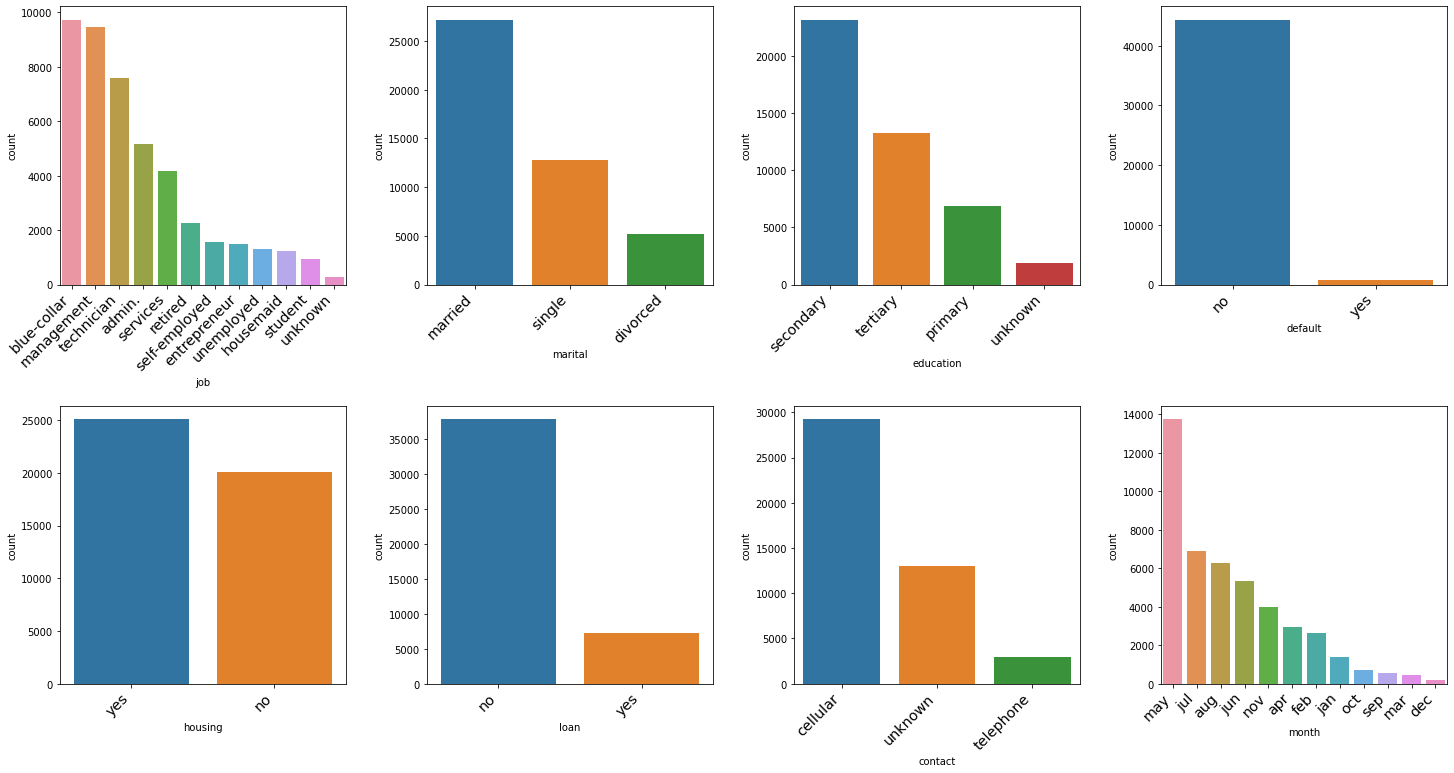

In [12]:
count = len(categoricals.columns)
fig, axes = plt.subplots(int(count / 4), 4, figsize=(20,10))
fig.tight_layout(w_pad=5.0, h_pad=10.0)

for ax, c in zip(axes.ravel(), categoricals):
  plot_categorical_count(ax, df, c)


- The campaign seems to focus on people with medium income, higher degree and without previous loans or defaults
- Interestingly enough, majority of the clients have no loan but own a house which means that the focus is on the wealthy people

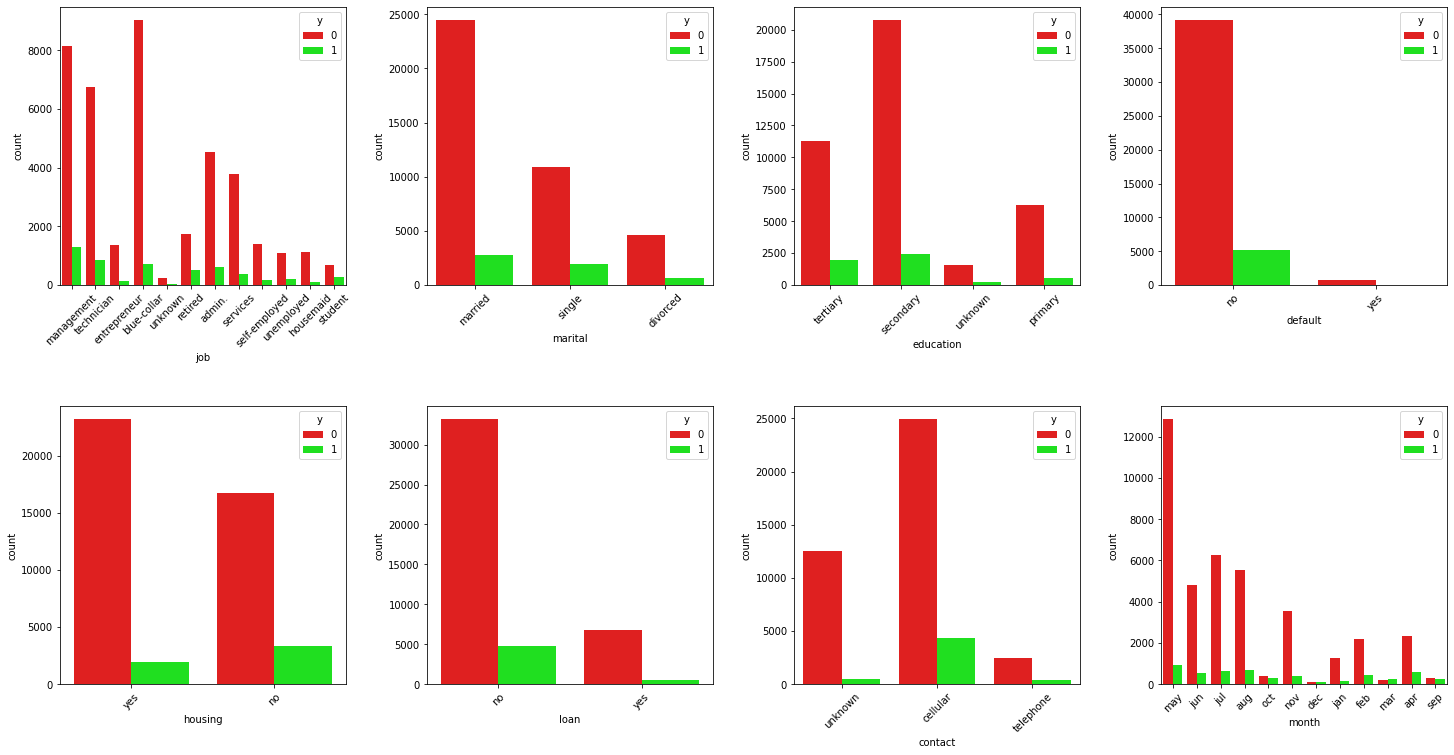

In [13]:
def plot_label_count(ax, data, feature):
  ax.tick_params(axis='x', labelrotation=45)
  sns.countplot(x=feature, hue='y', data=data, ax=ax, palette=['#FF0000',"#00FF00"])

count = len(categoricals.columns)
fig, axes = plt.subplots(int(count / 4), 4, figsize=(20,10))
fig.tight_layout(w_pad=5.0, h_pad=10.0)

for ax, c in zip(axes.ravel(), categoricals):
  plot_label_count(ax, df, c)

### Data preparation and cleaning

- No missing data so we don't have to impute any values


In [14]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


In [15]:
df['poutcome'].unique()

array(['unknown', 'failure', 'other', 'success'], dtype=object)

### Building a pipeline for the data transformation

In [20]:
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

# TODO: from sklearn.preprocessing import Binarizer
binarizer = FunctionTransformer(lambda df: df.replace({ 'yes': 1, 'no': 0}))

categorical_transform = make_column_transformer(
        # ('passthrough', make_column_selector(dtype_include=np.number)),
        (binarizer, ['housing', 'loan', 'default']),
        (OneHotEncoder(), ['job', 'month', 'marital', 'education', 'contact']),
)

In [37]:
num_binarizer = FunctionTransformer(lambda df: np.where(df > 1, 1, 0))
duration_minutes = FunctionTransformer(lambda x: np.ceil(x / 60))

numerical_transform = make_column_transformer(
    ('passthrough', ['age', 'balance', 'day', 'campaign', 'pdays']),
    (num_binarizer, ['previous']),
    (duration_minutes, ['duration'])
)

In [22]:
from sklearn.pipeline import make_union

full_pipeline = make_union(
  numerical_transform,
  categorical_transform
)

### Splitting data

In [23]:
from sklearn.model_selection import train_test_split

X = df.drop('y', axis = 1)
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
X_transformed = full_pipeline.fit_transform(X_train, y_train)

In [25]:
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import make_pipeline, Pipeline


# # Sklearn knows nothing about Pandas DataFrame, it accepts only numpy arrays
# num_attribs = list(numericals)
# cat_attribs = list(categoricals.drop('y', axis=1).columns)

# # FeatureUnion applies different transformers to the WHOLE of the input data
# # ColumnTransformer applies different transformers to different SUBSETS of the whole input data
# full_pipeline = ColumnTransformer([
#         ("numerical", num_pipeline, num_attribs),
#         ("categorical", cat_pipeline, cat_attribs)
#     ])

# le = LabelEncoder()
# prepared_labels = le.fit_transform(labels)

# prepared_features = categorical_transform.fit_transform(features, prepared_labels)



In [26]:
# from sklearn.base import BaseEstimator, TransformerMixin
# class TargetEncoder(BaseEstimator, TransformerMixin):
#     """Target encoder.
    
#     Replaces categorical column(s) with the mean target value for
#     each category.

#     """
    
#     def __init__(self, cols=None):
#         """Target encoder
        
#         Parameters
#         ----------
#         cols : list of str
#             Columns to target encode.  Default is to target 
#             encode all categorical columns in the DataFrame.
#         """
#         if isinstance(cols, str):
#             self.cols = [cols]
#         else:
#             self.cols = cols
        
        
#     def fit(self, X, y):
#         """Fit target encoder to X and y
        
#         Parameters
#         ----------
#         X : pandas DataFrame, shape [n_samples, n_columns]
#             DataFrame containing columns to encode
#         y : pandas Series, shape = [n_samples]
#             Target values.
            
#         Returns
#         -------
#         self : encoder
#             Returns self.
#         """
        
#         # Encode all categorical cols by default
#         if self.cols is None:
#             self.cols = [col for col in X 
#                          if str(X[col].dtype)=='object']

#         # Check columns are in X
#         for col in self.cols:
#             if col not in X:
#                 raise ValueError('Column \''+col+'\' not in X')

#         # Encode each element of each column
#         self.maps = dict() #dict to store map for each column
#         for col in self.cols:
#             tmap = dict()
#             uniques = X[col].unique()
#             for unique in uniques:
#                 tmap[unique] = y[X[col]==unique].mean()
#             self.maps[col] = tmap
            
#         return self

        
#     def transform(self, X, y=None):
#         """Perform the target encoding transformation.
        
#         Parameters
#         ----------
#         X : pandas DataFrame, shape [n_samples, n_columns]
#             DataFrame containing columns to encode
            
#         Returns
#         -------
#         pandas DataFrame
#             Input DataFrame with transformed columns
#         """
#         Xo = X.copy()
#         for col, tmap in self.maps.items():
#             vals = np.full(X.shape[0], np.nan)
#             for val, mean_target in tmap.items():
#                 vals[X[col]==val] = mean_target
#             Xo[col] = vals
#         return Xo
            
            
#     def fit_transform(self, X, y=None):
#         """Fit and transform the data via target encoding.
        
#         Parameters
#         ----------
#         X : pandas DataFrame, shape [n_samples, n_columns]
#             DataFrame containing columns to encode
#         y : pandas Series, shape = [n_samples]
#             Target values (required!).

#         Returns
#         -------
#         pandas DataFrame
#             Input DataFrame with transformed columns
#         """
#         return self.fit(X, y).transform(X, y)

In [27]:
pd.DataFrame(prepared_features).head()

NameError: ignored

### Training a model

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(prepared_features, prepared_labels)

In [ ]:
def plot_precision_recall_curve(y_true, y_pred):
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  plt.step(recall, precision, color='b', alpha=0.2, where='post')
  plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.1])
  plt.xlim([0.0, 1.0])

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, plot_roc_curve, precision_recall_curve, plot_confusion_matrix

def report_results(clf, X, y, preds):
  print('Number of non-subscribed:', len(y[y == 0]))
  print('Number of subscribed:', len(y[y == 1]))
  
  clf_report = classification_report(y, preds)
  print(clf_report)

  plot_precision_recall_curve(y, preds)
  plot_confusion_matrix(clf, X, y)
  plot_roc_curve(clf, X, y)
  auc = roc_auc_score(y, clf.predict_proba(X)[:,1])
  print('AUC score: {}'.format(auc))

In [ ]:
predictions = dtc.predict(prepared_features)

In [ ]:
report_results(dtc, prepared_features, prepared_labels, predictions)

Seems like the model overfit the data hard.
Let's try with unseen data since we have another, full dataset

#### Handling overfitting

Techniques:
- Regularization
- More meaningful (latent) features, getting rid of the higher degree features
- More data

In [ ]:
# Use unseen validation set
prepared_validation_features = full_pipeline.transform(validation_df.drop('y', axis=1))
prepared_validation_labels = le.transform(validation_df['y'])
predictions = dtc.predict(prepared_validation_features)

report_results(dtc, prepared_validation_features, prepared_validation_labels, predictions)

In [ ]:
# Create more balanced dataset for training
df_full['y'].value_counts()

In [ ]:
no = df_full[df_full['y'] == 'no'][:4000]
yes = df_full[df_full['y'] == 'yes'][:4000]

balanced_df = pd.concat([no, yes])

# Shuffle dataset so model won't pick up any correlations from the order
balanced_df = balanced_df.sample(frac=1)

In [ ]:
balanced_features = balanced_df.drop('y', axis=1)
features = full_pipeline.transform(balanced_features)
labels = le.transform(balanced_df['y'])

dtc2 = DecisionTreeClassifier(max_depth=8)
dtc2.fit(features, labels)

predictions = dtc2.predict(prepared_validation_features)
report_results(dtc2, prepared_validation_features, prepared_validation_labels, predictions)

In [ ]:
for name, importance in zip(balanced_features.columns, dtc2.feature_importances_):
    print(name, importance)

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

cv = StratifiedKFold(shuffle=True, n_splits=5, random_state=42)

grid_params = [{
    'max_depth': [1, 3, 5, 10, 20, 30],
    'min_samples_leaf': [1, 10, 50, 100]
}]

dtc3 = DecisionTreeClassifier()
grid_search = GridSearchCV(dtc3, grid_params, cv=cv,
                           scoring='recall',
                           return_train_score=True)

grid_search.fit(features, labels)

print('Best params', grid_search.best_params_)
print('Best estimator', grid_search.best_estimator_)
print('Mean test score', grid_search.cv_results_['mean_test_score'])
print('Test score deviation', grid_search.cv_results_['std_test_score'])

In [ ]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(prepared_validation_features)
report_results(best_model, prepared_validation_features, prepared_validation_labels, predictions)


### Testing ensemble method (RandomForestClassifier)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, oob_score=True)

grid_params_rf = [{
                'criterion': ['entropy'],
                'min_samples_leaf': [80, 100],
                'max_depth': [25, 27],
                'min_samples_split': [3, 5],
                'n_estimators' : [60, 70]
              }]

gridsearch_rf = GridSearchCV(rf, param_grid=grid_params_rf, scoring='accuracy', cv=cv)

In [ ]:
gridsearch_rf.fit(features, labels)

In [ ]:
print('Best params', gridsearch_rf.best_params_)
print('Best estimator', gridsearch_rf.best_estimator_)
print('Mean test score', gridsearch_rf.cv_results_['mean_test_score'])
print('Test score deviation', gridsearch_rf.cv_results_['std_test_score'])

In [ ]:
predictions = gridsearch_rf.best_estimator_.predict(prepared_validation_features)
report_results(gridsearch_rf.best_estimator_, prepared_validation_features, prepared_validation_labels, predictions)

In [ ]:
obb = []
estimator_count = list(range(5, 150, 5))

for i in estimator_count:
    random_forest = RandomForestClassifier(n_estimators=i, criterion='entropy',
                                           random_state=42, oob_score=True,
                                           max_depth=25, min_samples_leaf=80,
                                           min_samples_split=3)
    random_forest.fit(features, labels)
    obb.append(random_forest.oob_score_)

max_obb = max(obb)
optimal_estimator_count = estimator_count[np.argmax(obb)]
print('Max oob {} at number of estimators {}'.format(max_obb, optimal_estimator_count))
plt.plot(estimator_count, obb)
plt.xlabel('Estimator count')
plt.ylabel('Out-of-bag (oob) score')
plt.show();

In [ ]:
rf = RandomForestClassifier(n_estimators=optimal_estimator_count, criterion='entropy',
                                        random_state=42, oob_score=True,
                                        max_depth=25, min_samples_leaf=80,
                                        min_samples_split=3)

y_prepared = le.fit_transform(df_full['y'])
X_prepared = full_pipeline.fit_transform(df_full.drop('y', axis=1), y_prepared)
rf.fit(X_prepared, y_prepared)

In [ ]:
predictions = rf.predict(prepared_validation_features)
report_results(rf, prepared_validation_features, prepared_validation_labels, predictions)

### Final evaluation on test set
